## Import Statements

In [8]:
import copy

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, 
                             accuracy_score, balanced_accuracy_score)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [9]:
data = pd.read_json('../Data/data.json')

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(data[['label', 'algalBloomSheen_one_day', 'algalBloomSheen_three_day', 'algalBloomSheen_one_week']])

labels = data[['label']]
data = data.drop('label', axis='columns')

## Add Features

In [10]:
data['log_turbidity'] = np.log(data['turbidity'] + 1)

## Feature Correlation

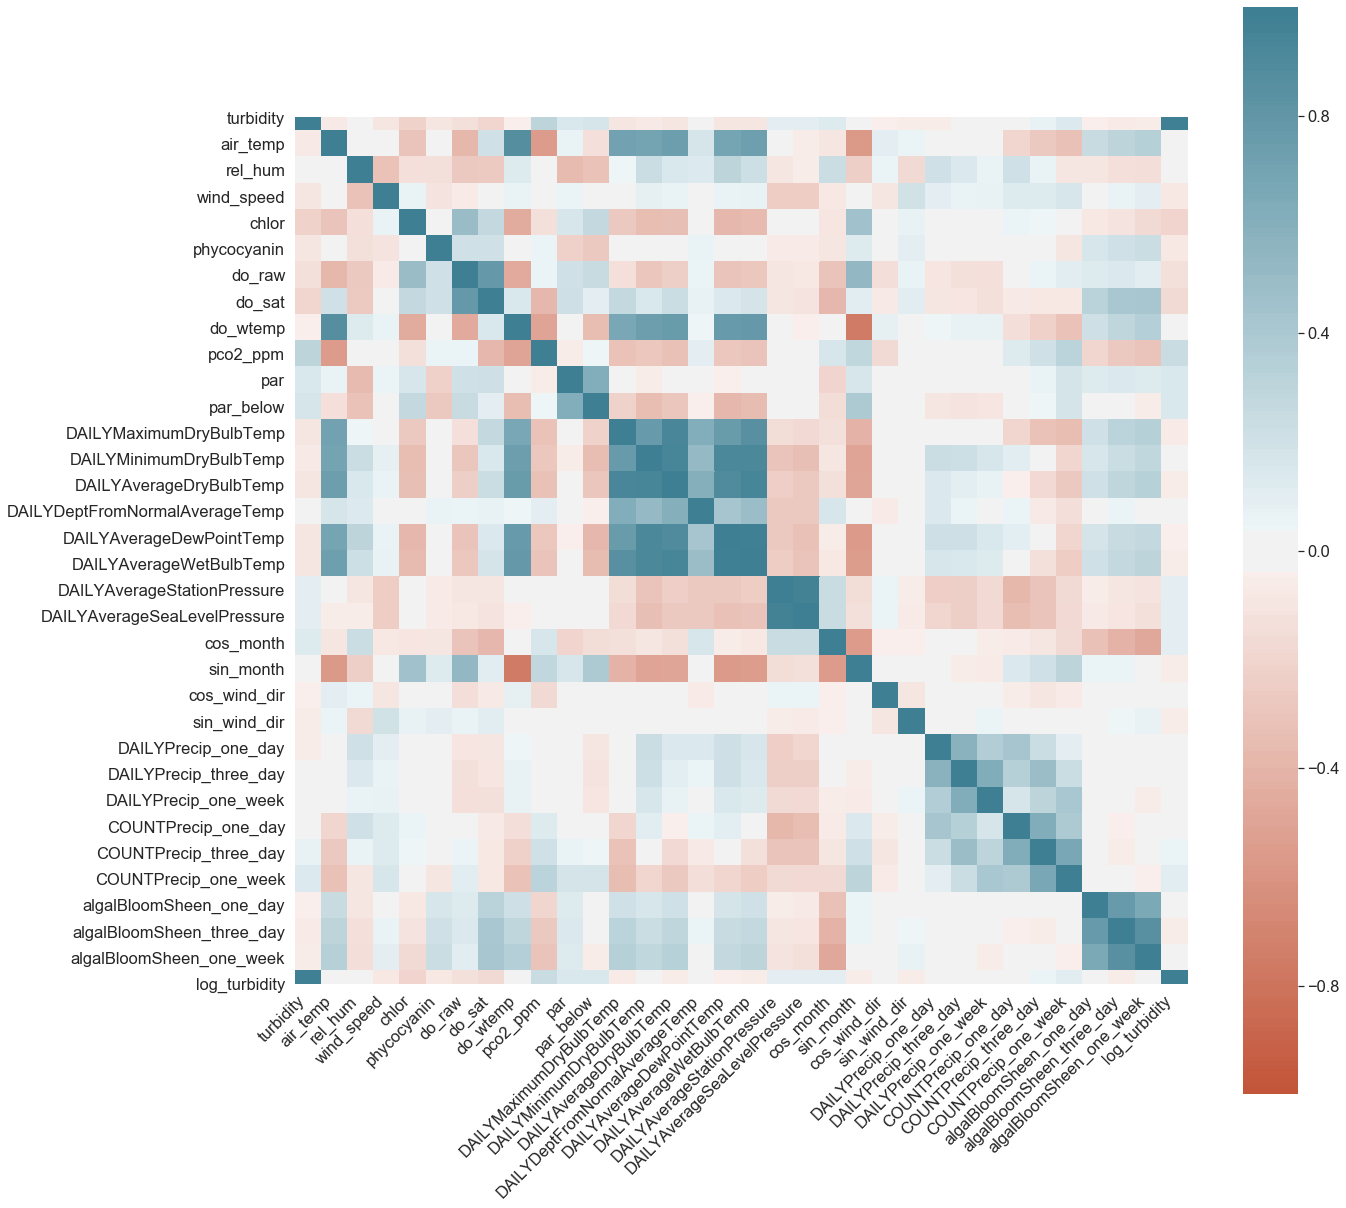

In [11]:
corr = data.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Choose Correlated Features to Remove

Removed features: 
	 log_turbidity
	 do_wtemp
	 DAILYAverageDryBulbTemp
	 DAILYAverageWetBulbTemp
	 DAILYAverageDewPointTemp
	 DAILYAverageSeaLevelPressure
	 algalBloomSheen_one_week


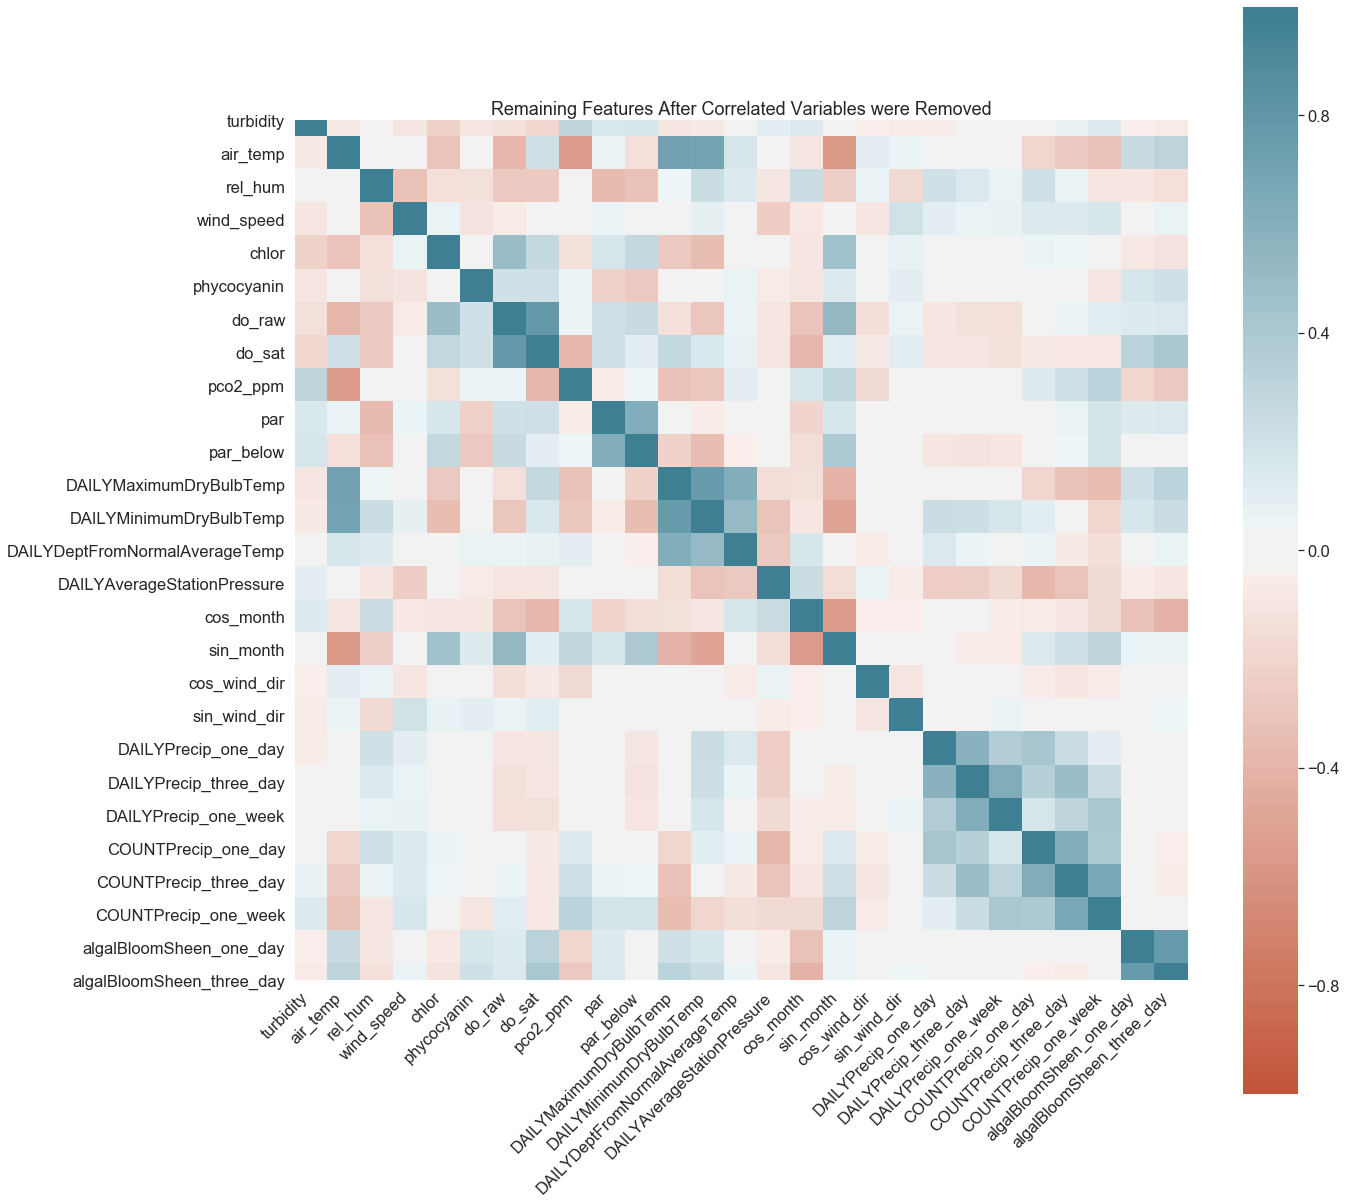

In [12]:
corr_thresh = 0.80  # threshold for correlation. for any two variables with correlation > thresh, one is removed

thresh = corr.abs() > corr_thresh

keep = copy.deepcopy(data.columns).to_list()

print('Removed features: ')
# keep features whose correlation with other features is <= corr_thresh
for i in range(0, len(thresh.index)):
    for j in range(i+1, len(thresh.columns)):
        if thresh.iloc[i, j]:
            if thresh.columns[j] in keep:
                print('\t', thresh.columns[j])
                keep.remove(thresh.columns[j])

new_corr = data[keep].corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    new_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Remaining Features After Correlated Variables were Removed');

### Split Data

In [13]:
train_size = 0.7

df = data[keep]

X_train, X_test, y_train, y_test = train_test_split(
    df.values,
    labels.values.ravel(),
    train_size=train_size,
    shuffle=True,
    stratify=labels.values.ravel()
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## AdaBoost

### Define Model

In [26]:
log = LogisticRegression(
    penalty='l1',
    tol=0.0001,
    C=1,
    fit_intercept=True,
    class_weight='balanced',
    solver='liblinear'
)

ab = AdaBoostClassifier(
    base_estimator=log,
    n_estimators=50,
    learning_rate=0.1,
    algorithm='SAMME.R'
)

### Evaluate

Accuracy: 0.6702
Balanced Accuracy: 0.6702
F1 Score: 0.0000

Confusion Matrix:


,0,1
0,128,0
1,63,0


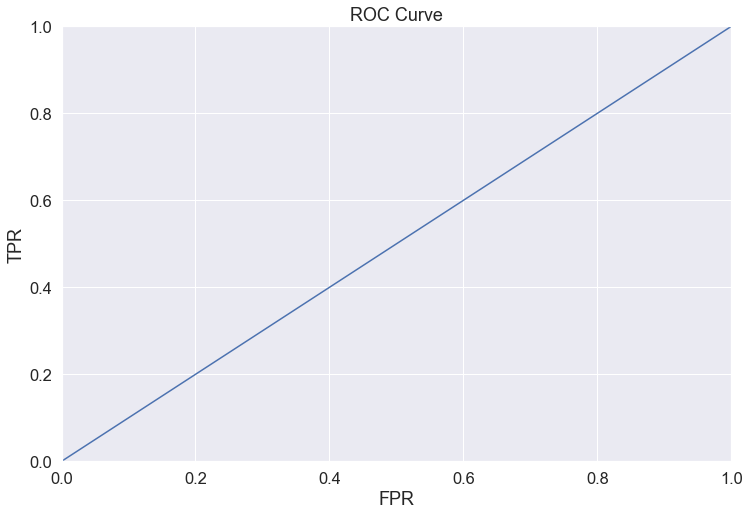

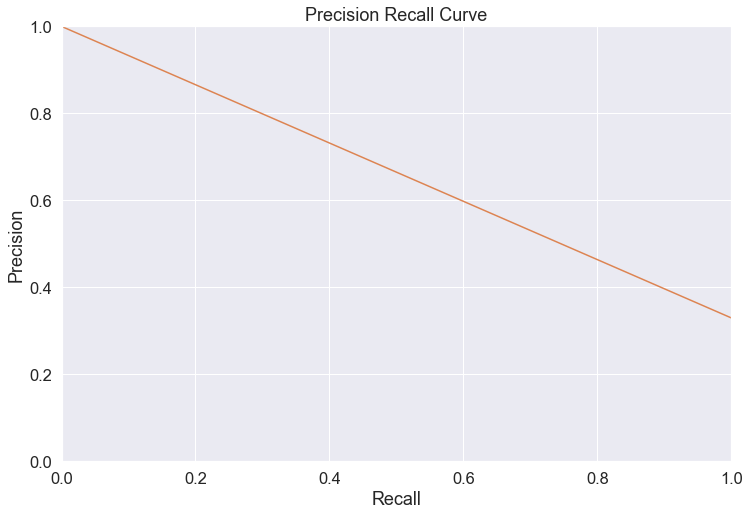

In [27]:
ab.fit(X_train, y_train)
y_pred = ab.predict(X_test)
y_prob = ab.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

### GridSearchCV

In [ ]:
ab_params = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

ab_grid = GridSearchCV(
    estimator=ab,
    param_grid=ab_params,
    scoring='accuracy',    # or f1, balanced_accuracy
    n_jobs=8,
    cv=5
)

ab_grid.fit(X_train, y_train)

print('Best AdaBoost Estimator:')
print(ab_grid.best_params_)
print('Balanced Accuracy:', ab_grid.best_score_)

In [ ]:
model = ab_grid.best_estimator_

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
balanced_acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)